In [1]:
# Use a pipeline as a high-level helper
import pandas as pd
import numpy as np
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AutoConfig
from scipy.special import softmax
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

pipe = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
# Read a sample of 50 sentence extractions from Diplomatic Pulse Data
ds_data = pd.read_excel('50sample_extractions_moreRestrictive.xlsx')
columns_to_check = ['positive_israel', 'negative_israel', 'positive_opt', 'negative_opt','positive_hamas','negative_hamas']

# Drop rows where all specified columns contain empty strings
data1 = pd.read_excel('50sample_extractions_moreRestrictive.xlsx')
#ds_data = data1[~data1[columns_to_check].eq('[]').all(axis=1)]
ds_data = ds_data.rename(columns={'Unnamed: 0': 'SId'})
# Store the original data in a new DataFrame
#data = ds_data
data = ds_data.copy()

In [7]:
idx_extraction = ds_data.columns.get_loc('positive_israel')
def clean_extractions(df):
    """
    Function that cleans extractions in the input DataFrame by converting them to strings & removing brackets
    """
    for column in df.columns[idx_extraction:(idx_extraction+6)]:
        df[column] = df[column].astype(str)
        df[column] = df[column].str.replace("[", "",regex=False)
        df[column] = df[column].str.replace("]", "",regex=False)
        df[column] = df[column].str.replace('[]', "",regex=False)
        df.loc[:,column] = df.loc[:,column].str.replace("", "",regex=False)
        df.loc[:,column] = df.loc[:,column].str.replace("\'", "",regex=True)
        df.loc[:,column].fillna('', inplace=True)
    return df

ds_data= clean_extractions(ds_data)

In [8]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL,model_max_length = 514,truncation=True)
config = AutoConfig.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
def roberta_score(text, idx):
    if text != '':
        inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
        if inputs['input_ids'].numel() == 0:
            return 0
        output = model(**inputs)
        if idx < 0 or idx >= output.logits.size(1):
            return 0
        preds = torch.softmax(output.logits, dim=1).tolist()[0]
        return preds[idx]
    else:
        return 0

def split_text_into_chunks(text, max_token_length=512):
    """
    Split longer text into chunks based on the maximum token length starting from the first sentence
    """
    # Split the text into sentences at punctuations .!?;
    sentences = re.split(r'([.!?;])', text)
    
    chunks = []
    current_chunk_tokens = []
    chunks_tokens = []
    current_chunk = ""

    for i, sentence in enumerate(sentences):
        # Tokenize the sentence
        tokens = tokenizer.encode(sentence)
        #print(i, len(tokens), sentence)
        #print("Current token length = ",len(current_chunk_tokens))
        
        # If adding the current sentence exceeds the max token length, start a new chunk
        if len(current_chunk_tokens) + len(tokens) > max_token_length:
            chunks_tokens.append(current_chunk_tokens)
            chunks.append(current_chunk)
            current_chunk_tokens = tokens
            current_chunk = sentence
     
        else:
            current_chunk_tokens += tokens
            current_chunk += sentence

    # If we have iterated over the entire text, append the remaining chunk
    if current_chunk:
        chunks_tokens.append(current_chunk_tokens)
        chunks.append(current_chunk)

    return chunks

def split_text_into_chunks_reverse(text, max_token_length=512):
    """
    Split longer text into chunks based on the maximum token length
    Chunks are created from the last sentence to the first.
    """
    # Split the text into sentences at punctuations .!?;
    sentences = re.split(r'([.!?;])', text)
    
    chunks = []
    current_chunk_tokens = []
    chunks_tokens = []
    current_chunk = ""

    # Iterate over sentences in reverse order
    for i in range(len(sentences) - 1, -1, -1):
        sentence = sentences[i]
        # Tokenize the sentence
        tokens = tokenizer.encode(sentence)
        #print(i, len(tokens), sentence)
        #print("Current token length = ",len(current_chunk_tokens))
        
        # If adding the current sentence exceeds the max token length, start a new chunk
        if len(current_chunk_tokens) + len(tokens) > max_token_length:
            chunks_tokens.append(current_chunk_tokens)
            chunks.append(current_chunk)
            current_chunk_tokens = tokens
            current_chunk = sentence
            
        else:
            current_chunk_tokens += tokens
            current_chunk = sentence + current_chunk  # Append to the beginning

    # If we have iterated over the entire text, append the remaining chunk
    if current_chunk:
        chunks_tokens.append(current_chunk_tokens)
        chunks.append(current_chunk)

    return chunks

def roberta_sentiment_score(text, idx):
    """
    main function to run roberta model given the text and index to sentiment type-positive/negative
    chunk statement if necessary, then evaluate chunks or entire statement, and return a score
    """
    if text != '':
        token_len = len(tokenizer.encode(text))
        max_allowable_token = 512

        if token_len > max_allowable_token:
            # split message into chunks
            chunk_scores=[]
            message_chunks = []
            message_chunks = split_text_into_chunks(text, max_token_length=max_allowable_token)
            for j,chunk in enumerate(message_chunks):
                print("Forward Chunk ......", j, "...........")
                #print(chunk)
                score= roberta_score(chunk, idx)
                chunk_len = len(tokenizer.encode(chunk))
                print("Chunk length :   ",chunk_len)
                weight = chunk_len / token_len
                print("Chunk weight :   ", weight)
                chunk_scores.append(score * weight)
            final_score_1 = np.sum(chunk_scores)

            chunk_scores=[]
            message_chunks = []
            message_chunks = split_text_into_chunks_reverse(text, max_token_length=max_allowable_token)
            for j,chunk in enumerate(message_chunks):
                print("Reverse Chunk ......", j, "...........")
                #print(chunk)
                score= roberta_score(chunk, idx)
                chunk_len = len(tokenizer.encode(chunk))
                print("Chunk length :   ",chunk_len)
                weight = chunk_len / token_len
                print("Chunk weight :   ", weight)
                chunk_scores.append(score * weight)
            final_score_2 = np.sum(chunk_scores)
            final_score = np.mean([final_score_1,final_score_2])
            
        else:
            final_score = roberta_score(text,idx)

        return final_score

    else:
        return 0

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\UNOCC-data\AppData\Local\Temp\ipykernel_12716\4088563102.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


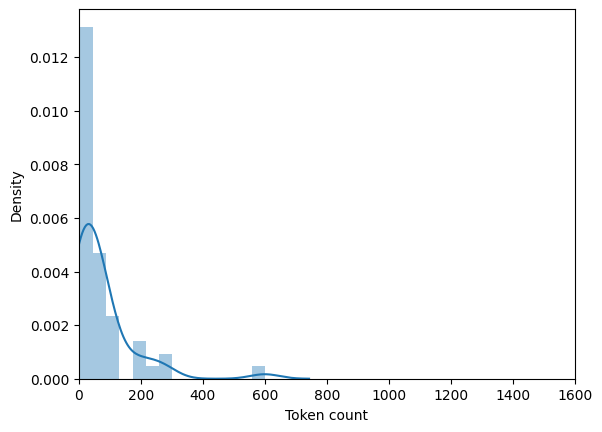

In [10]:
token_lens = []

for text in data.iloc[:,1]:
  tokens = tokenizer.encode(text, max_length=1000) # max_length for BERT is 512, but there are a few longer texts
  token_lens.append(len(tokens))

import seaborn as sns
from matplotlib import pyplot as plt
sns.distplot(token_lens)
plt.xlim([0, 1600]);
plt.xlabel('Token count');

In [11]:
score_pos_israel = "Roberta_positive_israel"
score_neg_israel = "Roberta_negative_israel"
score_pos_opt = "Roberta_positive_opt"
score_neg_opt = "Roberta_negative_opt"
score_pos_hamas = "Roberta_positive_hamas"
score_neg_hamas = "Roberta_negative_hamas"

fields_list = [score_pos_israel, score_neg_israel, score_pos_opt, score_neg_opt, score_pos_hamas, score_neg_hamas]

In [12]:
idx_extraction = ds_data.columns.get_loc('positive_israel')
def get_scores(ds_data=ds_data,df=data):
    """
    Function that takes a cleaned dataframe and original dataframe. Returns original dataframe plus sentiment scores calculated using the cleaned dataframe.
    Keeps the absolute values of scores for positive sentences, and -1 * absolute value of scores for the negative sentences
    """
    for i in range(0, len(fields_list)):
        column_index = idx_extraction + i
        if column_index % 2 == 0:
            score = ds_data.iloc[:,column_index].apply(lambda x: roberta_score(x,0))
        else:
            score = ds_data.iloc[:,column_index].apply(lambda x: roberta_score(x,2))
        df.loc[:,fields_list[i]] = score
        
    #Get index of the first score column, i.e. for positive_israel
    col_idx_score = df.columns.get_loc(fields_list[0])
    # Keep the absolute values for positive sentences, and -1 * absolute value for the negative sentences
    positive_extractions = [col_idx_score, (col_idx_score+2), (col_idx_score+4)]
    negative_extractions = [(col_idx_score+1), (col_idx_score+3), (col_idx_score+5)]
    df.iloc[:, positive_extractions] = df.iloc[:, positive_extractions].abs()
    df.iloc[:, negative_extractions] = -df.iloc[:, negative_extractions].abs()

    # Write the DataFrame to an Excel file
    df.to_excel('roberta-SentimentScores-DiplomaticPulseIsraelPalestine-SampleData.xlsx', index=False)
    return df

In [13]:
scores = get_scores(ds_data=ds_data,df=data)

In [14]:
# Get consolidated scores for each entity-Israel, oPt, Hamas by differencing the positive and negative scores. Store these scores in the original DataFrame
col_idx_score = data.columns.get_loc(fields_list[0])
data['Roberta-Israel'] = data.iloc[:,col_idx_score] + data.iloc[:,(col_idx_score+1)]
data['Roberta-Palestine'] = data.iloc[:,(col_idx_score+2)] + data.iloc[:,(col_idx_score+3)]
data['Roberta-Hamas'] = data.iloc[:,(col_idx_score+4)] + data.iloc[:,(col_idx_score+5)]
data = data.drop(columns=fields_list)
data.head()

,SId,positive_israel,negative_israel,positive_opt,negative_opt,positive_hamas,negative_hamas,Roberta-Israel,Roberta-Palestine,Roberta-Hamas
0,1,"['During her trip, the Minister will reaffirm ...",[],[],[],[],['discuss the impacts of Hamas’ terrorist atta...,0.455971,0.000000,-0.484890
1,2,"['As a friend to both Israel and Palestine, wh...",[],"['As a friend to both Israel and Palestine, wh...",[],[],['We oppose and condemn acts harming civilians.'],0.875551,0.863800,-0.862875
2,3,['the Foreign Minister expressed solidarity wi...,[],[],['Krišjānis Kariņš underlined the need for...,[],['following the violent attack by the Hamas te...,0.402532,-0.246841,-0.871031
3,4,"['Yesterday, I wrote to Israeli Foreign Minist...",[],[],[],[],['I again unreservedly condemn the attack by H...,0.108856,0.000000,-0.838302
4,5,['your visit is another tangible example of Am...,[],['We know Hamas doesn’t represent the Palestin...,[],[],['Hamas has shown itself to be an enemy of civ...,0.938202,0.007083,-0.931473


In [15]:
# Save consolidated scores in a dataframe
pred_scores = data.loc[:,['Roberta-Israel','Roberta-Palestine','Roberta-Hamas']]

# Read file with ground-truth scores and get the average scores for each entity                 
gtdata= pd.read_excel('AverageSentiment Scoring-RLU-DiplomaticPulse-Israel-oPt_issuingCountry.xlsx')
actual_avgscores = gtdata.iloc[:,12:15]

# Match index of ground truth scores with predicted scores because empty extractions were filtered out
acs = actual_avgscores.loc[data.index]
#acs.head()

In [16]:
mae_results = pd.DataFrame()

individual_maes = []
for i in range(3):
    abs_diff = abs(pred_scores.iloc[:, i] - acs.iloc[:, i])
    mae = np.mean(abs_diff)
    mae_results[i] = [mae]
    individual_maes.append(mae)

# Calculate overall MSE
overall_mae = np.mean(individual_maes)
mae_results['Overall'] = [overall_mae]

mae_results.index = ['MAE']
print(mae_results)

            0         1         2   Overall
MAE  0.316332  0.104166  0.214194  0.211564


In [17]:
mse_results = pd.DataFrame()

individual_mses = []
for i in range(3):
    squared_diff = (pred_scores.iloc[:, i] - acs.iloc[:, i]) ** 2
    mse = np.mean(squared_diff)
    mse_results[i] = [mse]
    individual_mses.append(mse)

# Calculate overall MSE
overall_mse = np.mean(individual_mses)
mse_results['Overall'] = [overall_mse]

mse_results.index = ['MSE']
print(mse_results)

            0         1         2   Overall
MSE  0.176358  0.032382  0.101057  0.103266


In [18]:
summary=pd.concat([mae_results,mse_results])
summary.columns = ['Israel', 'oPt','Hamas','Overall']
summary

,Israel,oPt,Hamas,Overall
MAE,0.316332,0.104166,0.214194,0.211564
MSE,0.176358,0.032382,0.101057,0.103266


In [19]:
# Get average ground truth scores in data
data['gt-score_israel'] = acs['Israel.3']
data['gt-score_opt'] = acs['Occupied Palestine Territory.3']
data['gt-score_hamas'] = acs['Hamas.3']
data.head()

,SId,positive_israel,negative_israel,positive_opt,negative_opt,positive_hamas,negative_hamas,Roberta-Israel,Roberta-Palestine,Roberta-Hamas,gt-score_israel,gt-score_opt,gt-score_hamas
0,1,"['During her trip, the Minister will reaffirm ...",[],[],[],[],['discuss the impacts of Hamas’ terrorist atta...,0.455971,0.000000,-0.484890,0.666667,0.250000,-0.750000
1,2,"['As a friend to both Israel and Palestine, wh...",[],"['As a friend to both Israel and Palestine, wh...",[],[],['We oppose and condemn acts harming civilians.'],0.875551,0.863800,-0.862875,0.000000,0.250000,-0.083333
2,3,['the Foreign Minister expressed solidarity wi...,[],[],['Krišjānis Kariņš underlined the need for...,[],['following the violent attack by the Hamas te...,0.402532,-0.246841,-0.871031,0.583333,-0.250000,-0.750000
3,4,"['Yesterday, I wrote to Israeli Foreign Minist...",[],[],[],[],['I again unreservedly condemn the attack by H...,0.108856,0.000000,-0.838302,0.416667,0.250000,-0.833333
4,5,['your visit is another tangible example of Am...,[],['We know Hamas doesn’t represent the Palestin...,[],[],['Hamas has shown itself to be an enemy of civ...,0.938202,0.007083,-0.931473,1.000000,0.083333,-0.916667


In [20]:
# Create 5 equal sized classes in the range -1 to 1 and classify both predicted and average ground truth scores
def to_sentiment(score):
  score = score
  if score <= -0.6:
    return "strong negative"
  elif score > -0.6 and score <= -0.2:
    return "weak negative"
  elif score > -0.2 and score < 0.2:
    return "neutral"
  elif score >=0.2 and score < 0.6:
    return "weak positive"
  elif score >= 0.6:
    return "strong positive"

data['sentiment_israel'] = data['Roberta-Israel'].apply(lambda x: to_sentiment(x))
data['sentiment_opt'] = data['Roberta-Palestine'].apply(lambda x: to_sentiment(x))
data['sentiment_hamas'] = data['Roberta-Hamas'].apply(lambda x: to_sentiment(x))
data[['gt_israel', 'gt_opt', 'gt_hamas']] = acs[['Israel.3','Occupied Palestine Territory.3','Hamas.3']].applymap(to_sentiment)
data.head()

,SId,positive_israel,negative_israel,positive_opt,negative_opt,positive_hamas,negative_hamas,Roberta-Israel,Roberta-Palestine,Roberta-Hamas,gt-score_israel,gt-score_opt,gt-score_hamas,sentiment_israel,sentiment_opt,sentiment_hamas,gt_israel,gt_opt,gt_hamas
0,1,"['During her trip, the Minister will reaffirm ...",[],[],[],[],['discuss the impacts of Hamas’ terrorist atta...,0.455971,0.000000,-0.484890,0.666667,0.250000,-0.750000,weak positive,neutral,weak negative,strong positive,weak positive,strong negative
1,2,"['As a friend to both Israel and Palestine, wh...",[],"['As a friend to both Israel and Palestine, wh...",[],[],['We oppose and condemn acts harming civilians.'],0.875551,0.863800,-0.862875,0.000000,0.250000,-0.083333,strong positive,strong positive,strong negative,neutral,weak positive,neutral
2,3,['the Foreign Minister expressed solidarity wi...,[],[],['Krišjānis Kariņš underlined the need for...,[],['following the violent attack by the Hamas te...,0.402532,-0.246841,-0.871031,0.583333,-0.250000,-0.750000,weak positive,weak negative,strong negative,weak positive,weak negative,strong negative
3,4,"['Yesterday, I wrote to Israeli Foreign Minist...",[],[],[],[],['I again unreservedly condemn the attack by H...,0.108856,0.000000,-0.838302,0.416667,0.250000,-0.833333,neutral,neutral,strong negative,weak positive,weak positive,strong negative
4,5,['your visit is another tangible example of Am...,[],['We know Hamas doesn’t represent the Palestin...,[],[],['Hamas has shown itself to be an enemy of civ...,0.938202,0.007083,-0.931473,1.000000,0.083333,-0.916667,strong positive,neutral,strong negative,strong positive,neutral,strong negative


In [21]:
class_names=['strong negative', 'weak negative', 'neutral','weak positive','strong positive']
titles = ['Israel', 'oPt', 'Hamas']
#Israel
x1=data.iloc[:,16] #ground-truth
y1=data.iloc[:,13] #predicted
cm1 = confusion_matrix(x1, y1, labels=class_names)
#oPt
x2=data.iloc[:,17]
y2=data.iloc[:,14]
cm2 = confusion_matrix(x2, y2, labels=class_names)
#Hamas
x3=data.iloc[:,18]
y3=data.iloc[:,15]
cm3 = confusion_matrix(x3, y3, labels=class_names)

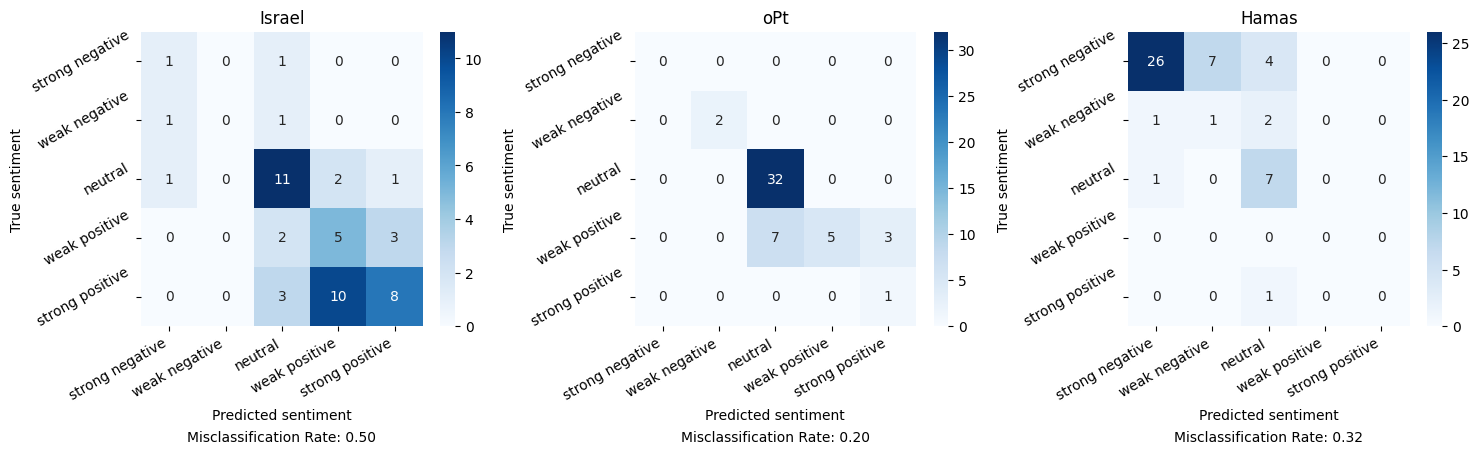

In [22]:
# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
    # Set the title for the subplot
    ax.set_title(titles[i])
    # Create a heatmap for each confusion matrix
    if i == 0:
        confusion_matrix = cm1
    elif i == 1:
        confusion_matrix = cm2
    else:
        confusion_matrix = cm3
    
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", ax=ax, xticklabels=class_names, yticklabels=class_names)
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=30, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    
    # Set axis labels
    ax.set_xlabel('Predicted sentiment')
    ax.set_ylabel('True sentiment')
    
    # Calculate and display misclassification rate
    total = np.sum(confusion_matrix)
    misclassified = total - np.trace(confusion_matrix)
    misclassification_rate = misclassified / total
    ax.text(0.5, -0.39, f'Misclassification Rate: {misclassification_rate:.2f}', ha='center', transform=ax.transAxes)

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()
fig = plt.figure()

#plt.savefig('gpt35-equalboundary.png', transparent=False)
plt.close()

In [23]:
writer = pd.ExcelWriter('Roberta-equalBC-DiplomaticPulseData.xlsx', engine='openpyxl')
data.to_excel(writer, sheet_name='Main', index=False)
ds_data.to_excel(writer, sheet_name='All_scores', index=False)
summary.to_excel(writer, sheet_name='Summary', index=True)
writer.book.save('Roberta-equalBC-DiplomaticPulseData.xlsx')

Confidence Intervals for Israel, oPt, and Hamas scores

In [24]:
np.random.seed(101)
entity=['Israel', 'oPt','Hamas']
for j in range(0,3):
    # Sample predicted and ground truth sentiment scores
    predicted_scores = pred_scores.iloc[:,j]
    ground_truth_scores = acs.iloc[:,j]

    # Number of bootstrap resamples
    num_resamples = 1000
    confidence_level = 0.95  

    # Calculate the differences between predicted and ground truth scores
    difference_scores = np.array(predicted_scores) - np.array(ground_truth_scores)
    bootstrap_means = np.empty(num_resamples)
    # Bootstrap resampling and mean calculation
    for i in range(num_resamples):
        #Resample with replacement
        resample_indices = np.random.choice(len(difference_scores), size=len(difference_scores), replace=True)
    
        # Calculate the mean difference for the resampled dataset
        bootstrap_means[i] = np.mean(difference_scores[resample_indices])

    # Calculate the confidence interval
    lower_percentile = (1 - confidence_level) / 2 * 100
    upper_percentile = (confidence_level + (1 - confidence_level) / 2) * 100
    confidence_interval = np.percentile(bootstrap_means, [lower_percentile, upper_percentile])

    print(f"For {entity[j]}, {int(confidence_level * 100)}% Confidence Interval for Difference:", confidence_interval)
    print(f"Width of Confidence Interval : {confidence_interval[1]-confidence_interval[0]}")

For Israel, 95% Confidence Interval for Difference: [-0.20380445  0.01841028]
Width of Confidence Interval : 0.222214729549984
For oPt, 95% Confidence Interval for Difference: [-0.07754626  0.01628302]
Width of Confidence Interval : 0.09382928448558472
For Hamas, 95% Confidence Interval for Difference: [0.00967539 0.17582298]
Width of Confidence Interval : 0.16614759293198578
